# Copy Kernel Test
Este cuaderno prueba el kernel `copy_kernel` copiando una matriz de números complejos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import Overlay, allocate
%matplotlib inline

In [8]:
ol = Overlay('bufferMatrix.bit')  # Reemplace con el bitstream que contiene copy_kernel
ip = ol.copy_kernel_0

In [9]:
print(ol.copy_kernel_0.register_map)  # o el nombre exacto del IP


RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  in_r_1 = Register(in_r=write-only),
  in_r_2 = Register(in_r=write-only),
  out_r_1 = Register(out_r=write-only),
  out_r_2 = Register(out_r=write-only)
}


In [10]:
N = 64
TOTAL = N * N
x = np.linspace(-3, 3, N, dtype=np.float32)
X, Y = np.meshgrid(x, x)
sigma = 0.8
gaussian = np.exp(-(X**2 + Y**2) / (2 * sigma**2)).astype(np.float32)
in_matrix = gaussian.astype(np.complex64)
in_buffer = allocate(shape=(TOTAL,), dtype=np.complex64)
out_buffer = allocate(shape=(TOTAL,), dtype=np.complex64)
np.copyto(in_buffer, in_matrix.reshape(TOTAL))

In [11]:
ip.write(0x10, in_buffer.physical_address)
ip.write(0x1c, out_buffer.physical_address)
ip.write(0x00, 1)  # ap_start
while (ip.read(0x00) & 0x2) == 0:
    pass
out_matrix = np.array(out_buffer).reshape(N, N)

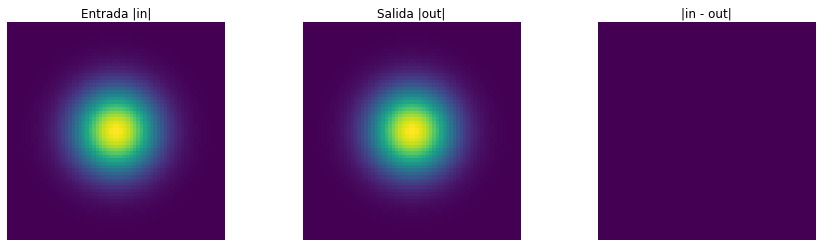

Error máximo: 0.0


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(np.abs(in_matrix))
axes[0].set_title('Entrada |in|')
axes[1].imshow(np.abs(out_matrix))
axes[1].set_title('Salida |out|')
diff = out_matrix - in_matrix
axes[2].imshow(np.abs(diff))
axes[2].set_title('|in - out|')
for ax in axes: ax.axis('off')
plt.show()
print('Error máximo:', np.max(np.abs(diff)))